## **Step 0: Dependencies**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

# Set seaborn theme
sns.set_theme(style="darkgrid", context="talk")

## **Step 1: Data Validation & Sanity Checks**

### **Load & Inspect Data**

In [2]:
# Load data
data = pd.read_csv(r"../data/raw/synthetic_mmm_data.csv", parse_dates=["date"])

In [3]:
df = data.copy()

In [4]:
# Basic checks
df.head()

,date,sales,tv_spend,digital_spend,search_spend,social_spend,promo_flag,holiday_flag,price_index
0,03-01-2022,29011.05,22786.98,21601.60,40654.89,15775.27,0,1,1.0
1,10-01-2022,29706.99,49130.41,16116.10,19279.15,13211.15,1,0,1.0
2,17-01-2022,32372.99,21434.65,18175.76,35425.63,45629.19,0,0,1.0
3,24-01-2022,30390.97,24020.76,24444.36,11883.62,14045.73,0,0,1.0
4,31-01-2022,29615.47,16091.23,8807.03,12850.70,26097.52,0,0,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           156 non-null    object 
 1   sales          156 non-null    float64
 2   tv_spend       156 non-null    float64
 3   digital_spend  156 non-null    float64
 4   search_spend   156 non-null    float64
 5   social_spend   156 non-null    float64
 6   promo_flag     156 non-null    int64  
 7   holiday_flag   156 non-null    int64  
 8   price_index    156 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 11.1+ KB


In [6]:
df.describe()

,sales,tv_spend,digital_spend,search_spend,social_spend,promo_flag,holiday_flag,price_index
count,156.000000,156.000000,156.000000,156.00000,156.000000,156.000000,156.000000,156.000000
mean,31923.921923,23772.256474,22146.211218,23271.55500,23507.860256,0.166667,0.038462,1.038590
std,1676.399516,9639.932902,8573.547967,9585.00835,10803.799926,0.373878,0.192927,0.023041
min,27859.770000,8202.340000,8807.030000,8486.72000,8520.050000,0.000000,0.000000,1.000000
25%,30869.575000,16499.172500,15306.175000,15619.14750,15130.047500,0.000000,0.000000,1.020000
50%,31825.695000,22431.400000,21517.620000,23001.33500,21537.480000,0.000000,0.000000,1.040000
75%,33002.780000,27778.442500,27672.867500,28434.06750,29729.577500,0.000000,0.000000,1.060000
max,36038.420000,51966.100000,51438.180000,48925.69000,52657.520000,1.000000,1.000000,1.080000


### **Missing & Invalid Values**

In [7]:
# Missing values
df.isna().sum()

date             0
sales            0
tv_spend         0
digital_spend    0
search_spend     0
social_spend     0
promo_flag       0
holiday_flag     0
price_index      0
dtype: int64

In [8]:
# Negative values check
numeric_cols = df.select_dtypes(include="number")

negative_counts = (numeric_cols < 0).sum()
negative_counts

sales            0
tv_spend         0
digital_spend    0
search_spend     0
social_spend     0
promo_flag       0
holiday_flag     0
price_index      0
dtype: int64

## **Step 2: Exploratory Data Analysis (EDA)**

### **Sales Over Time**

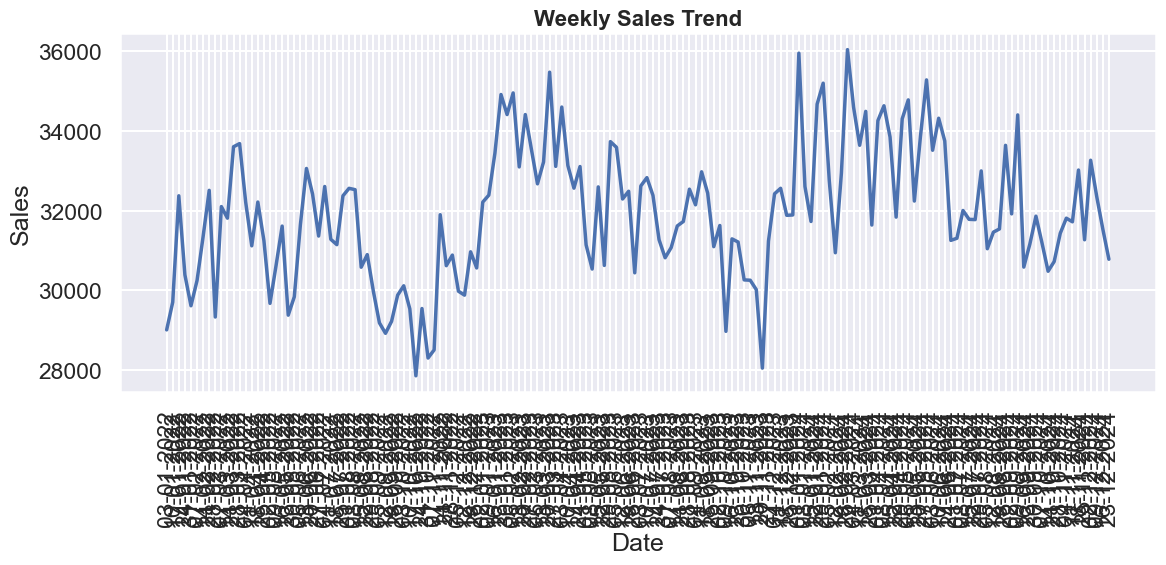

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x="date",
    y="sales",
    linewidth=2.5
)

plt.title("Weekly Sales Trend", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.xticks(rotation=90)
# plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### **Spend Patterns Per Channel**

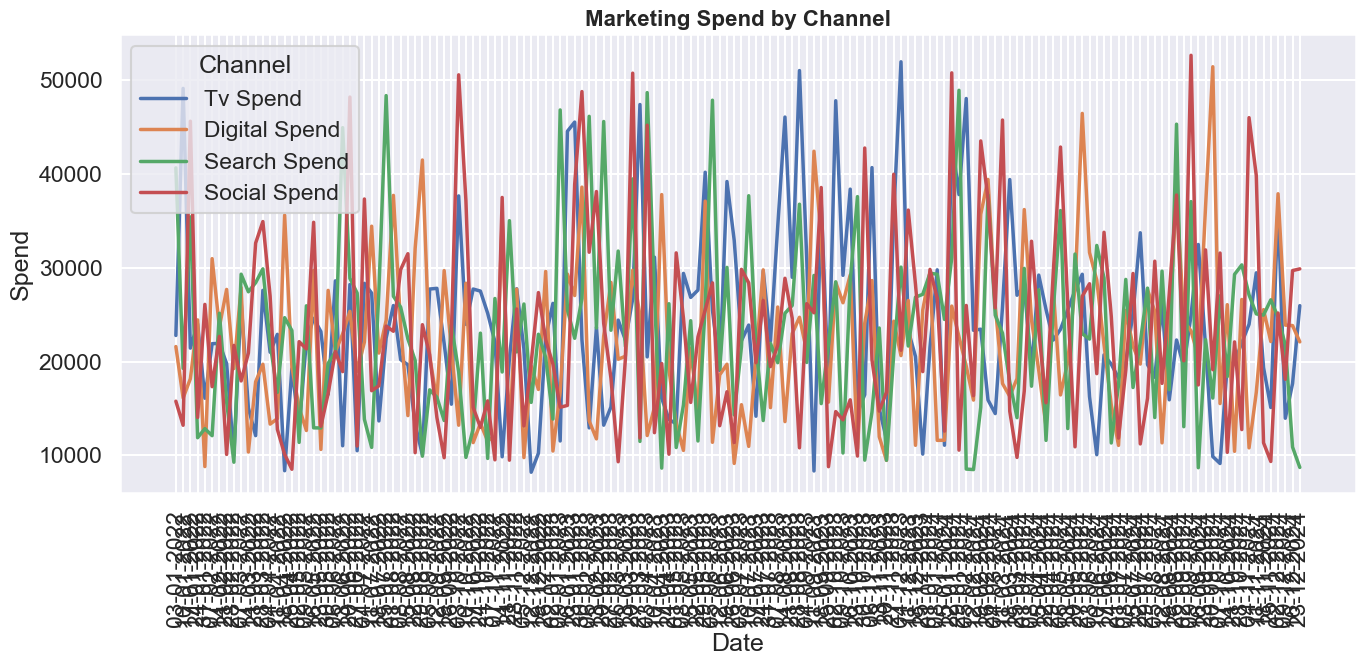

In [10]:
plt.figure(figsize=(14, 7))

spend_cols = ["tv_spend", "digital_spend", "search_spend", "social_spend"]

for col in spend_cols:
    sns.lineplot(
        data=df,
        x="date",
        y=col,
        linewidth=2.5,
        label=col.replace("_", " ").title()
    )

plt.title("Marketing Spend by Channel", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Spend")

plt.xticks(rotation=90)
plt.legend(title="Channel", frameon=True)
plt.tight_layout()
plt.show()

### **Promo & Holiday Sanity Check**

In [11]:
promo_sales = df.groupby("promo_flag")["sales"].mean()
holiday_sales = df.groupby("holiday_flag")["sales"].mean()

print("Avg sales without promo:", promo_sales[0])
print("Avg sales with promo:", promo_sales[1])

print("Avg sales without holiday:", holiday_sales[0])
print("Avg sales with holiday:", holiday_sales[1])

Avg sales without promo: 31750.98330769231
Avg sales with promo: 32788.615
Avg sales without holiday: 31909.47906666667
Avg sales with holiday: 32284.993333333332


### **Correlation Heatmap**

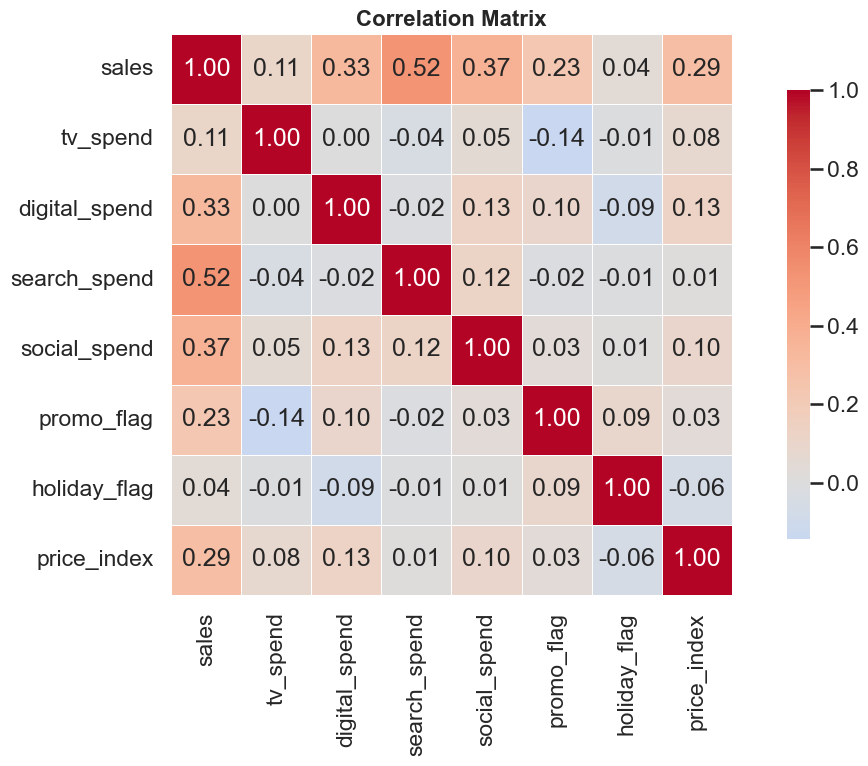

In [12]:
corr = df[["sales"] + spend_cols + ["promo_flag", "holiday_flag", "price_index"]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

### **Weekly Seasonality Check**

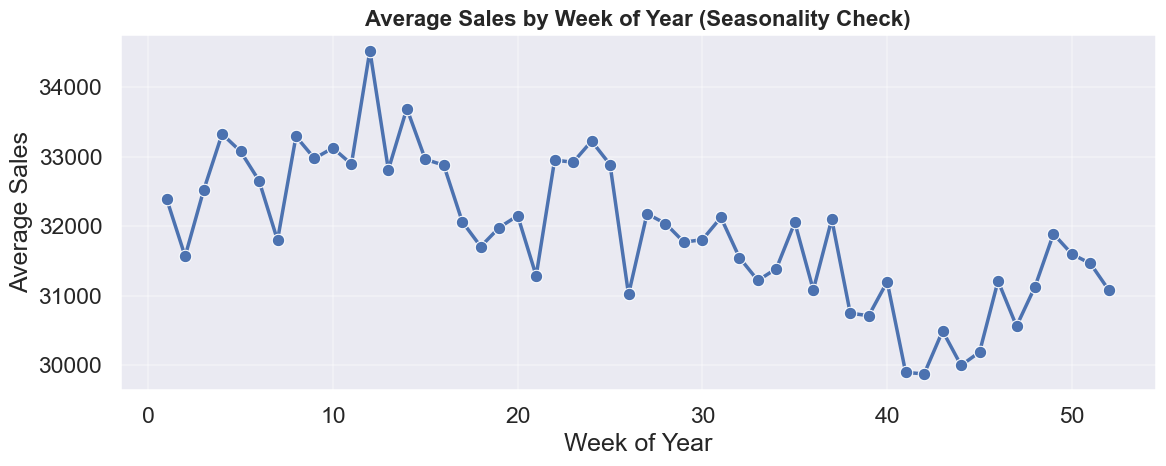

In [13]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

df["week_of_year"] = df["date"].dt.isocalendar().week

weekly_sales = (
    df.groupby("week_of_year", as_index=False)["sales"]
      .mean()
)

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=weekly_sales,
    x="week_of_year",
    y="sales",
    marker="o",
    linewidth=2.5
)

plt.title("Average Sales by Week of Year (Seasonality Check)", fontsize=16, weight="bold")
plt.xlabel("Week of Year")
plt.ylabel("Average Sales")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **Step 3: Baseline MMM (Linear Regression)**

### **Prepare Data**

In [14]:
df =  data.copy()

In [15]:
# Features for baseline MMM
features = ["tv_spend", "digital_spend", "search_spend", "social_spend", 
            "promo_flag", "holiday_flag", "price_index"]
target = "sales"

X = df[features]
y = df[target]

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

### **Train Linear Regression Model**

In [16]:
# Initialize & train model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Coefficients
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": baseline_model.coef_
}).sort_values(by="coefficient", ascending=False)

print("Feature Coefficients:")
coef_df

Feature Coefficients:


,feature,coefficient
6,price_index,30026.288642
4,promo_flag,923.516173
5,holiday_flag,458.578138
2,search_spend,0.089861
1,digital_spend,0.051500
3,social_spend,0.040652
0,tv_spend,0.012143


### **Predictions & Evaluation**

In [17]:
# Predict on test set
y_pred = baseline_model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Baseline MMM RMSE: {rmse:.2f}")
print(f"Baseline MMM R²: {r2:.2f}")

Baseline MMM RMSE: 1400.37
Baseline MMM R²: -0.28


### **Visualize Predicted vs Actual Sales**

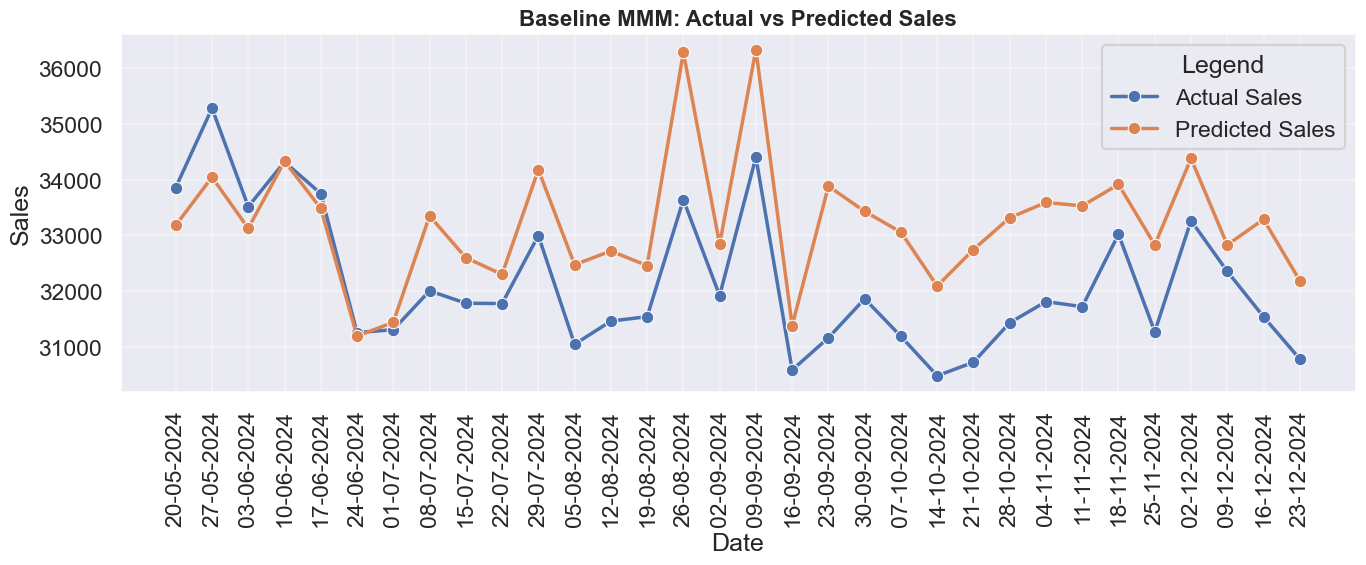

In [18]:
plt.figure(figsize=(14, 6))

# Plot actual sales
sns.lineplot(
    x=df['date'].iloc[-len(y_test):],
    y=y_test,
    marker='o',
    linewidth=2.5,
    label='Actual Sales'
)

# Plot predicted sales
sns.lineplot(
    x=df['date'].iloc[-len(y_test):],
    y=y_pred,
    marker='o',
    linewidth=2.5,
    label='Predicted Sales'
)

plt.title("Baseline MMM: Actual vs Predicted Sales", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=90)  # Rotate dates for readability
plt.grid(alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

## **STEP 4 — Feature Engineering (Adstock + Saturation)**

### **Define Helper Functions**

In [19]:
# -----------------------------
# Adstock function
# -----------------------------
def adstock_geometric(x, decay=0.5):
    """
    Applies geometric adstock to a time series
    """
    result = np.zeros_like(x)
    for t in range(len(x)):
        if t == 0:
            result[t] = x[t]
        else:
            result[t] = x[t] + decay * result[t-1]
    return result

# -----------------------------
# Hill Saturation function
# -----------------------------
def hill_saturation(x, alpha=1, gamma=0.5):
    """
    Hill function: captures diminishing returns
    alpha = maximum effect
    gamma = half-saturation constant
    """
    return alpha * (x ** gamma) / ( (x ** gamma) + (1 ** gamma) )

📌 Notes:

decay = 0.4–0.6 typical for digital channels

gamma controls saturation curve steepness

### **Apply Adstock + Saturation to Channels**

In [20]:
# Copy original data to new df for feature engineering
df_mmm = data.copy()

# Define channel params (can tune later)
channel_params = {
    "tv_spend": {"decay": 0.6, "gamma": 0.5},
    "digital_spend": {"decay": 0.4, "gamma": 0.6},
    "search_spend": {"decay": 0.3, "gamma": 0.5},
    "social_spend": {"decay": 0.5, "gamma": 0.4},
}

for channel, params in channel_params.items():
    adstocked = adstock_geometric(df_mmm[channel].values, decay=params["decay"])
    df_mmm[f"{channel}_adstock"] = hill_saturation(adstocked, alpha=1, gamma=params["gamma"])


### **Quick Check**

In [21]:
df_mmm[[ "tv_spend", "tv_spend_adstock", 
         "digital_spend", "digital_spend_adstock"]].head(10)

,tv_spend,tv_spend_adstock,digital_spend,digital_spend_adstock
0,22786.98,0.993419,21601.60,0.997498
1,49130.41,0.996026,16116.10,0.997694
2,21434.65,0.995904,18175.76,0.997862
3,24020.76,0.995917,24444.36,0.998147
4,16091.23,0.995625,8807.03,0.997595
5,21910.73,0.995674,30974.64,0.998275
6,21937.65,0.995704,23693.69,0.998264
7,19787.04,0.995635,27694.55,0.998357
8,9986.37,0.995098,19256.90,0.998179
9,26376.65,0.995596,27893.43,0.998334


### **Prepare Features for Regularized MMM**

In [22]:
features_mmm = [
    "tv_spend_adstock", "digital_spend_adstock", 
    "search_spend_adstock", "social_spend_adstock", 
    "promo_flag", "holiday_flag", "price_index"
]

X_mmm = df_mmm[features_mmm]
y_mmm = df_mmm["sales"]

X_train, X_test, y_train, y_test = train_test_split(X_mmm, y_mmm, test_size=0.2, shuffle=False)

## **STEP 5 — Regularized MMM**

### **Initialize & Train Ridge Regression**

In [23]:
# Regularized regression
ridge_model = Ridge(alpha=1.0)  # alpha can be tuned

# Train
ridge_model.fit(X_train, y_train)

# Coefficients
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": ridge_model.coef_
}).sort_values(by="coefficient", ascending=False)

print("Regularized MMM Coefficients:")
coef_df

Regularized MMM Coefficients:


,feature,coefficient
6,price_index,1496.811983
4,promo_flag,934.603823
5,holiday_flag,345.536247
3,social_spend_adstock,164.193533
2,search_spend_adstock,119.746067
0,tv_spend_adstock,29.994620
1,digital_spend_adstock,22.551581


### **Predictions & Evaluation**

In [24]:
y_pred = ridge_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Regularized MMM RMSE: {rmse:.2f}")
print(f"Regularized MMM R²: {r2:.2f}")

Regularized MMM RMSE: 1194.46
Regularized MMM R²: 0.07


### **Visualize Predicted vs Actual Sales**

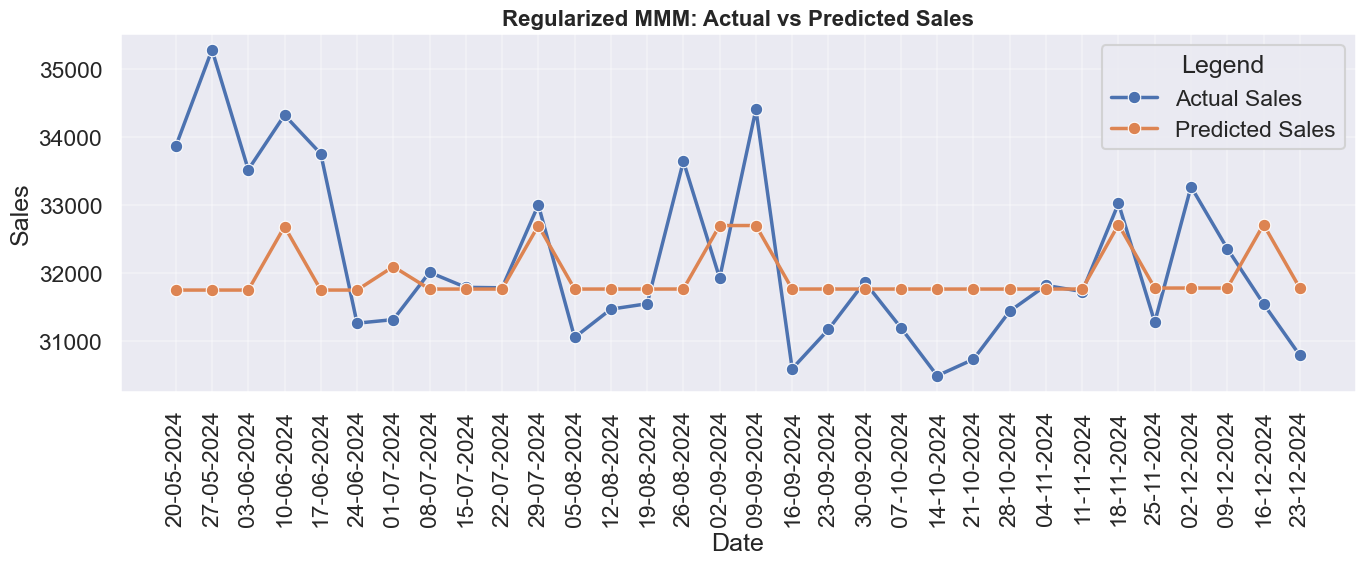

In [25]:
plt.figure(figsize=(14, 6))

# Plot actual sales
sns.lineplot(
    x=df_mmm['date'].iloc[-len(y_test):],
    y=y_test,
    marker='o',
    linewidth=2.5,
    label='Actual Sales'
)

# Plot predicted sales
sns.lineplot(
    x=df_mmm['date'].iloc[-len(y_test):],
    y=y_pred,
    marker='o',
    linewidth=2.5,
    label='Predicted Sales'
)

plt.title("Regularized MMM: Actual vs Predicted Sales", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=90)  # Rotate dates for readability
plt.grid(alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

### **Channel Contribution Analysis**

In [26]:
channel_cols = ["tv_spend_adstock", "digital_spend_adstock", "search_spend_adstock", "social_spend_adstock"]

contributions = {}
for col in channel_cols:
    contributions[col] = ridge_model.coef_[X_train.columns.get_loc(col)] * X_train[col].sum()

contrib_df = pd.DataFrame.from_dict(contributions, orient='index', columns=['total_contribution']).sort_values(by='total_contribution', ascending=False)

print("Total Channel Contributions:")
contrib_df

Total Channel Contributions:


,total_contribution
social_spend_adstock,20081.047707
search_spend_adstock,14764.573146
tv_spend_adstock,3703.935274
digital_spend_adstock,2791.056660


## **STEP 6 — ROI & Channel Contribution Analysis**

### **Calculate Incremental Sales**

In [27]:
# Channel columns (adstock features)
channel_cols = ["tv_spend_adstock", "digital_spend_adstock", "search_spend_adstock", "social_spend_adstock"]

# Calculate contribution per channel
contributions = {}
for col in channel_cols:
    # Contribution = coefficient * total spend (adstocked)
    contributions[col] = ridge_model.coef_[X_train.columns.get_loc(col)] * X_mmm[col].sum()

contrib_df = pd.DataFrame.from_dict(contributions, orient='index', columns=['incremental_sales']).sort_values(by='incremental_sales', ascending=False)
contrib_df

,incremental_sales
social_spend_adstock,25265.055158
search_spend_adstock,18575.038021
tv_spend_adstock,4659.609783
digital_spend_adstock,3511.443227


### **Calculate ROI**

In [28]:
# Total actual spend per channel (raw spend)
total_spend = df_mmm[channel_cols].sum()

# ROI = Incremental Sales ÷ Total Spend
contrib_df['total_spend'] = total_spend.values
contrib_df['ROI'] = contrib_df['incremental_sales'] / contrib_df['total_spend']
contrib_df

,incremental_sales,total_spend,ROI
social_spend_adstock,25265.055158,155.348184,162.635021
search_spend_adstock,18575.038021,155.707189,119.294672
tv_spend_adstock,4659.609783,155.120235,30.038697
digital_spend_adstock,3511.443227,153.873631,22.820305


In [29]:
def calculate_roi(model, df, channel, increase_pct=0.1):
    df_copy = df.copy()

    # Baseline prediction
    baseline_sales = model.predict(X_mmm).sum()

    # Increase spend
    df_copy[channel] *= (1 + increase_pct)

    # Recompute adstock
    params = channel_params[channel]
    adstocked = adstock_geometric(df_copy[channel].values, decay=params["decay"])
    df_copy[f"{channel}_adstock"] = hill_saturation(adstocked, gamma=params["gamma"])

    # New prediction
    X_new = df_copy[features_mmm]
    new_sales = model.predict(X_new).sum()

    # ROI
    delta_sales = new_sales - baseline_sales
    delta_spend = df[channel].sum() * increase_pct

    return delta_sales / delta_spend

In [30]:
roi_results = {}
for channel in ["tv_spend", "digital_spend", "search_spend", "social_spend"]:
    roi_results[channel] = calculate_roi(ridge_model, df_mmm, channel)

roi_results_df = pd.DataFrame.from_dict(roi_results, orient="index", columns=["ROI"])
roi_results_df

,ROI
tv_spend,0.000002
digital_spend,0.000001
search_spend,0.000013
social_spend,0.000035


### **Visualize Contribution & ROI**

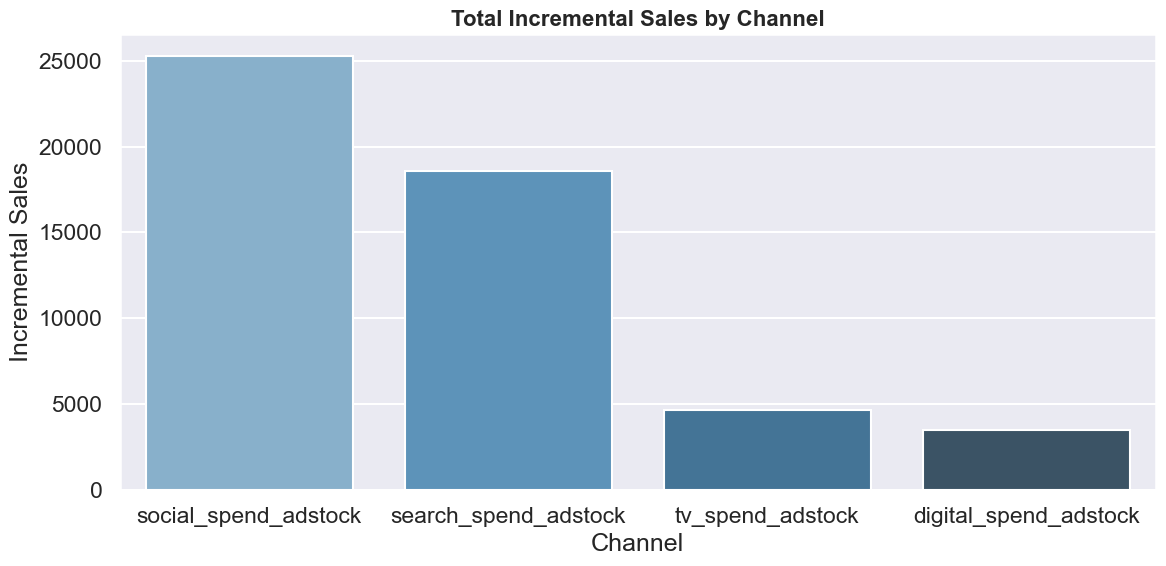

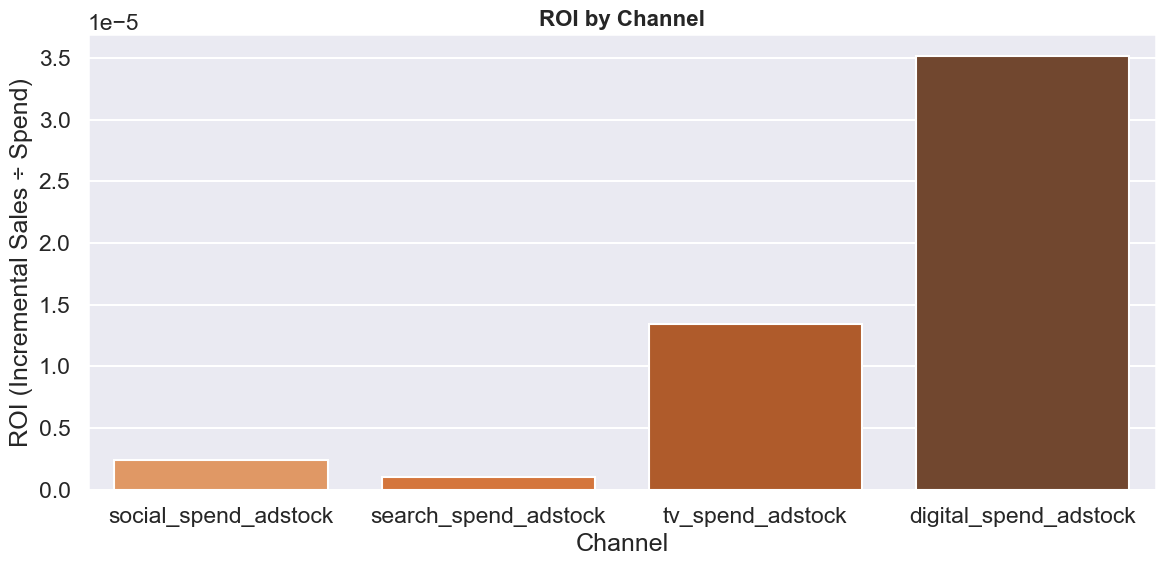

In [31]:
# Bar plot: Total Incremental Sales by Channel
plt.figure(figsize=(12,6))
sns.barplot(
    x=contrib_df.index,
    y=contrib_df['incremental_sales'],
    palette="Blues_d"
)
plt.title("Total Incremental Sales by Channel", fontsize=16, weight="bold")
plt.ylabel("Incremental Sales")
plt.xlabel("Channel")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot: ROI by Channel
plt.figure(figsize=(12,6))
sns.barplot(
    x=contrib_df.index,
    y=roi_results_df['ROI'],
    palette="Oranges_d"
)
plt.title("ROI by Channel", fontsize=16, weight="bold")
plt.ylabel("ROI (Incremental Sales ÷ Spend)")
plt.xlabel("Channel")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Optional: Waterfall Chart for Contributions**

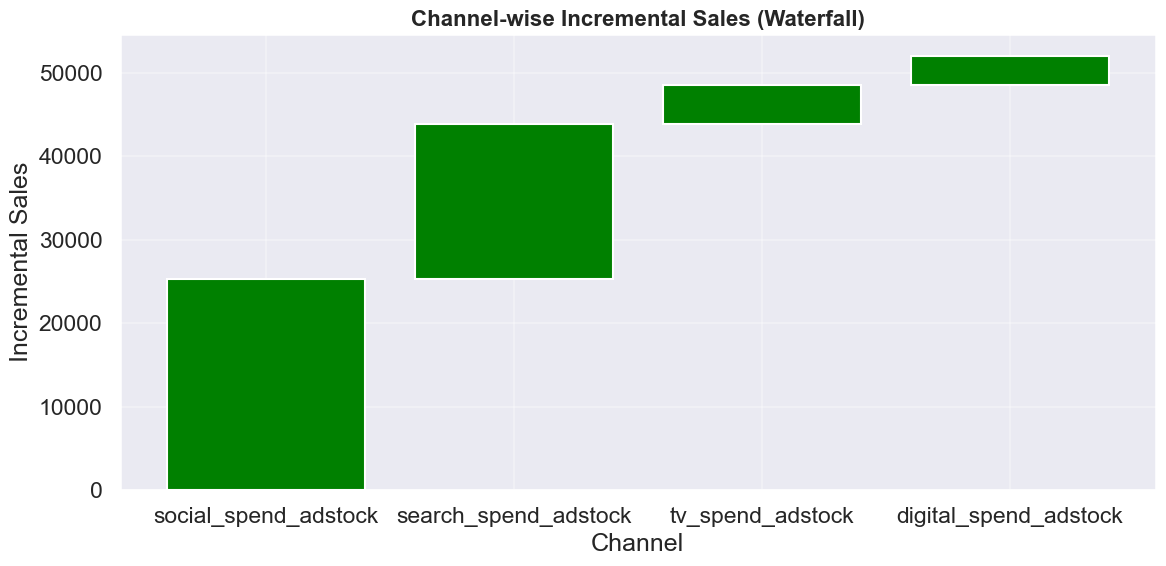

In [32]:
channels = contrib_df.index
values = contrib_df['incremental_sales'].values

# Colors: green for positive, red for negative
colors = ['green' if v > 0 else 'red' for v in values]

# Compute cumulative positions for bars
cum_values = np.zeros(len(values))
for i in range(1, len(values)):
    cum_values[i] = cum_values[i-1] + values[i-1]

plt.figure(figsize=(12,6))

# Plot bars
for i in range(len(values)):
    plt.bar(channels[i], values[i], bottom=cum_values[i], color=colors[i])

plt.title("Channel-wise Incremental Sales (Waterfall)", fontsize=16, weight="bold")
plt.ylabel("Incremental Sales")
plt.xlabel("Channel")
# plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **STEP 7 — Scenario Simulation & Budget Optimization (MMM Simulator)**

### **Baseline Prediction**

In [33]:
baseline_sales = ridge_model.predict(X_mmm).sum()
baseline_sales

np.float64(4973269.281593012)

### **Create Scenario Function**

In [34]:
def simulate_budget_change(
    df,
    model,
    channel_changes: dict
):
    """
    channel_changes example:
    {
        'tv_spend': -0.2,
        'search_spend': 0.2
    }
    """
    df_sim = df.copy()

    # Apply budget changes
    for channel, pct_change in channel_changes.items():
        df_sim[channel] *= (1 + pct_change)

        # Recompute adstock + saturation
        params = channel_params[channel]
        adstocked = adstock_geometric(df_sim[channel].values, decay=params["decay"])
        df_sim[f"{channel}_adstock"] = hill_saturation(adstocked, gamma=params["gamma"])

    # Predict new sales
    X_sim = df_sim[features_mmm]
    simulated_sales = model.predict(X_sim).sum()

    return simulated_sales

### **Scenario 1**

#### **🔁 Shift 20% Budget from TV → Search**

In [35]:
scenario_1_sales = simulate_budget_change(
    df_mmm,
    ridge_model,
    {
        "tv_spend": -0.2,
        "search_spend": 0.2
    }
)

lift_1 = scenario_1_sales - baseline_sales
lift_1

np.float64(6.8337858859449625)

Interpretation:

Positive lift → good reallocation

Negative lift → saturation or wrong move

### **Scenario 2**

#### **🚀 Increase Social Spend by 30%**

In [36]:
scenario_2_sales = simulate_budget_change(
    df_mmm,
    ridge_model,
    {
        "social_spend": 0.3
    }
)

lift_2 = scenario_2_sales - baseline_sales
lift_2

np.float64(34.350964192301035)

### **Scenario Comparison Table**

In [37]:
scenario_df = pd.DataFrame({
    "Scenario": [
        "Baseline",
        "TV → Search (20%)",
        "Social +30%"
    ],
    "Total Sales": [
        baseline_sales,
        scenario_1_sales,
        scenario_2_sales
    ],
    "Sales Lift": [
        0,
        lift_1,
        lift_2
    ]
})

scenario_df

,Scenario,Total Sales,Sales Lift
0,Baseline,4.973269e+06,0.000000
1,TV → Search (20%),4.973276e+06,6.833786
2,Social +30%,4.973304e+06,34.350964


### **Automated Budget Optimizer (Advanced)**

In [38]:
results = []

for channel in ["tv_spend", "digital_spend", "search_spend", "social_spend"]:
    sales = simulate_budget_change(
        df_mmm,
        ridge_model,
        {channel: 0.2}
    )
    lift = sales - baseline_sales

    results.append({
        "channel": channel,
        "sales_lift_20pct": lift
    })

pd.DataFrame(results).sort_values(by="sales_lift_20pct", ascending=False)

,channel,sales_lift_20pct
3,social_spend,24.240753
2,search_spend,9.130557
0,tv_spend,1.696878
1,digital_spend,0.683074


## **STEP 8 — Demand Forecasting + MMM Integration**

### **Baseline Demand Model (Time Series)**

#### **Create Baseline Dataset**

In [39]:
df_baseline = df_mmm.copy()

df_baseline["date"] = pd.to_datetime(df_baseline["date"], dayfirst=True)

df_baseline["weekofyear"] = df_baseline["date"].dt.isocalendar().week

baseline_features = [
    "price_index",
    "promo_flag",
    "holiday_flag",
    "weekofyear"
]

X_base = df_baseline[baseline_features]
y_base = df_baseline["sales"]

### **Train Baseline Regression**

In [40]:
baseline_model = LinearRegression()
baseline_model.fit(X_base, y_base)

baseline_pred = baseline_model.predict(X_base)

### **Visualize Baseline vs Actual**

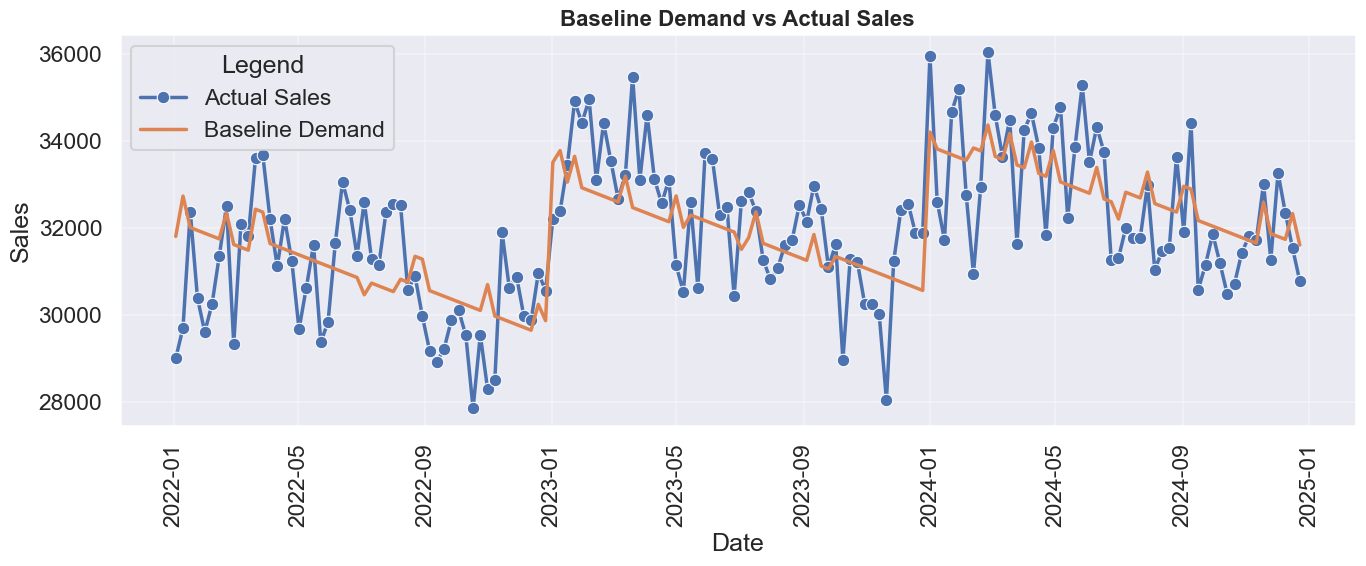

In [41]:
plt.figure(figsize=(14, 6))

# Actual sales
sns.lineplot(
    x=df_baseline["date"],
    y=y_base,
    marker="o",
    linewidth=2.5,
    label="Actual Sales"
)

# Baseline demand
sns.lineplot(
    x=df_baseline["date"],
    y=baseline_pred,
    # marker="o"
    linewidth=2.5,
    label="Baseline Demand"
)

plt.title("Baseline Demand vs Actual Sales", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=90)  # Rotate for readability
plt.grid(alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

### **Marketing Uplift Estimation**

In [42]:
marketing_uplift = ridge_model.predict(X_mmm)

In [43]:
df_baseline["baseline_sales"] = baseline_pred
df_baseline["marketing_uplift"] = y_base - baseline_pred

### **Future Data Generation (Next 12 Weeks)**

In [44]:
df.head()

,date,sales,tv_spend,digital_spend,search_spend,social_spend,promo_flag,holiday_flag,price_index
0,03-01-2022,29011.05,22786.98,21601.60,40654.89,15775.27,0,1,1.0
1,10-01-2022,29706.99,49130.41,16116.10,19279.15,13211.15,1,0,1.0
2,17-01-2022,32372.99,21434.65,18175.76,35425.63,45629.19,0,0,1.0
3,24-01-2022,30390.97,24020.76,24444.36,11883.62,14045.73,0,0,1.0
4,31-01-2022,29615.47,16091.23,8807.03,12850.70,26097.52,0,0,1.0


In [45]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df_mmm["date"] = pd.to_datetime(df_mmm["date"], dayfirst=True)

future_weeks = 12
last_date = df["date"].max()

future_df = pd.date_range(
    start=last_date + pd.Timedelta(weeks=1),
    periods=future_weeks,
    freq="W"
)

future_data = pd.DataFrame({
    "date": future_df,
    "weekofyear": future_df.isocalendar().week.astype(int),
    "price_index": 1.0,
    "promo_flag": [0]*future_weeks,
    "holiday_flag": [0]*future_weeks,

    # Optimized spends
    "social_spend": df["social_spend"].mean() * 1.3,
    "search_spend": df["search_spend"].mean() * 1.2,
    "tv_spend": df["tv_spend"].mean() * 0.8,
    "digital_spend": df["digital_spend"].mean() * 0.7,
})

### **Apply Adstock to Future Data**

In [46]:
for channel, params in channel_params.items():
    adstocked = adstock_geometric(
        np.concatenate([df[channel].values, future_data[channel].values]),
        decay=params["decay"]
    )[-future_weeks:]

    future_data[f"{channel}_adstock"] = hill_saturation(adstocked, gamma=params["gamma"])

### **Forecast Future Sales**

In [47]:
future_base = baseline_model.predict(
    future_data[baseline_features]
)

In [48]:
future_uplift = ridge_model.predict(
    future_data[features_mmm]
)

In [49]:
future_data["forecast_sales"] = future_base + future_uplift
future_data[["date", "forecast_sales"]]

,date,forecast_sales
2025-01-05,2025-01-05,63794.766332
2025-01-12,2025-01-12,63729.897118
2025-01-19,2025-01-19,63664.983690
2025-01-26,2025-01-26,63600.057290
2025-02-02,2025-02-02,63535.126381
2025-02-09,2025-02-09,63470.193762
2025-02-16,2025-02-16,63405.260453
2025-02-23,2025-02-23,63340.326854
2025-03-02,2025-03-02,63275.393131
2025-03-09,2025-03-09,63210.459354


### **Visualization**

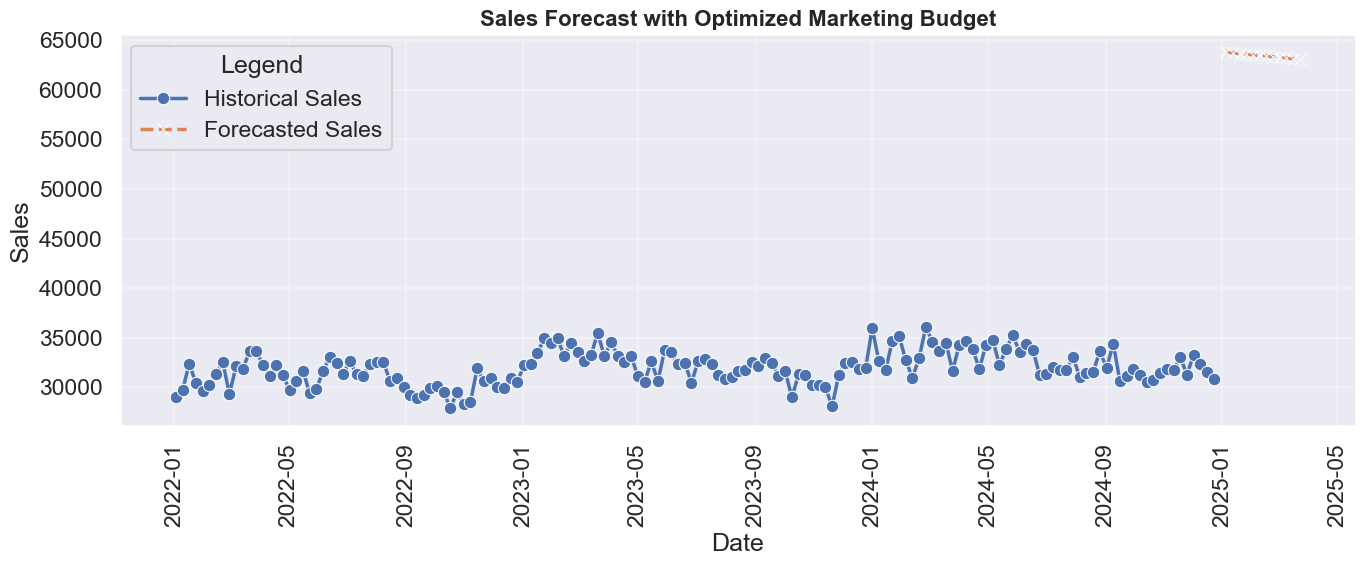

In [50]:
plt.figure(figsize=(14,6))

# Historical Sales
sns.lineplot(
    x=df["date"],
    y=df["sales"],
    marker="o",
    linewidth=2.5,
    label="Historical Sales"
)

# Forecasted Sales
sns.lineplot(
    x=future_data["date"],
    y=future_data["forecast_sales"],
    linestyle="--",
    marker="x",
    linewidth=2.5,
    label="Forecasted Sales"
)

plt.title("Sales Forecast with Optimized Marketing Budget", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=90)  # Rotate dates for readability
plt.grid(alpha=0.3)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()